In [1]:
import numpy as np
import pandas as pd

In [2]:
# Read in the files
train_data = pd.read_csv('../assets/train_complete_mg.csv')
test_data = pd.read_csv('../assets/test_complete_mg.csv')

In [3]:
# Continuing to borrow Ritika's EDA function.
# Need to ensure types are workable

def eda(dataframe):
    print "dataframe types \n", dataframe.dtypes, "\n"
    print "dataframe shape \n", dataframe.shape, "\n"

In [7]:
eda(train_data)

dataframe types 
Species                   object
Block                      int64
Trap                      object
Latitude                 float64
Longitude                float64
AddressAccuracy            int64
NumMosquitos               int64
WnvPresent                 int64
YMD                       object
PIPIENS                    int64
RESTUANS                   int64
SALINARIUS                 int64
TERRITANS                  int64
Station                    int64
Tmax                       int64
Tmin                       int64
DewPoint                   int64
WetBulb                  float64
Sunrise                   object
Sunset                    object
PrecipTotal              float64
StnPressure              float64
SeaLevel                 float64
ResultSpeed              float64
ResultDir                  int64
AvgSpeed                 float64
Tavg_int                   int64
Normal_Temp              float64
Depart_calc              float64
RA                        

In [24]:
##### Mega Function to run all of the models of relevance ###
# Mostly derived from 6.08 work and Project 3, with a couple modifications #

### NEED TO MODIFY FUNCTION BEFORE RUNNING MODEL 
### IF WISHING TO USE model_metric (also needs commented back in)

### Scale = "Yes"; skip otherwise
### TTS = "Yes" or "No" on whether or not to run a train/test split
### Boost = "Yes"; skip otherwise
### X = Pre-defined dataframe and its columns of interest
### y = Pre-defined dataframe target column
### model_to_run = Model() wishing to run this test on
### grid_search_dictionary = parameter dictionary to feed 
            ### into grid_search for the model of interest

def evaluate_model(Scale, TTS, Boost, X, y, model_to_run, grid_search_dictionary):
    
    if Scale == "Yes":
        from sklearn.preprocessing import Normalizer
        normalizer = Normalizer()
        X = normalizer.fit_transform(X)
        
    if TTS == "Yes":
        # Perform the train/test split:
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)   
        
    if TTS == "No":
        # Skip TTS:
        X_train = X
        X_test = X
        y_train = y
        y_test = y
    
    ##### Run the model
    model = model_to_run
    model.fit(X_train, y_train)
    
    # Generate predictions
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test) # Need the second value
    
    probability_list = [] # Becomes the list of probabilities
    for i in probabilities:
        probability_list.append(i[1])
    probabilities = probability_list
        
    
    # Create cross-val score on train
    from sklearn.model_selection import cross_val_score
    
    # Perform 10-fold cross validation
    trn_cv_scores = cross_val_score(model, X_train, y_train, cv=10)
    
    # Create scores on test group
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    from sklearn.metrics import roc_auc_score
    
    # Comment in if running a model with this attribute
    # model_metric = model.feature_importances_   
    # print model_metric
    
        # Model specific output attribute
        # Have to reassign each function run
    
    acc_score = accuracy_score(y_test, predictions)
    con_matrix = confusion_matrix(y_test, predictions)
    class_rep = classification_report(y_test, predictions)
    roc_auc = roc_auc_score(y_test, probabilities)

    
    ##### Run Bagging
    from sklearn.ensemble import BaggingClassifier
    
    bagging = BaggingClassifier(base_estimator=model)
    bagging.fit(X_train, y_train)
    bagging_predictions = bagging.predict(X_test)
    bagging_probabilities = bagging.predict_proba(X_test)
    
    bag_probability_list = [] # Becomes the list of probabilities
    for i in bagging_probabilities:
        bag_probability_list.append(i[1])
    bagging_probabilities = bag_probability_list
    
    bg_acc_score = accuracy_score(y_test, bagging_predictions)
    bg_con_matrix = confusion_matrix(y_test, bagging_predictions)
    bg_class_rep = classification_report(y_test, bagging_predictions)
    bg_roc_auc = roc_auc_score(y_test, bagging_probabilities)
    
    
    ##### Run a GridSearch
    from sklearn.model_selection import GridSearchCV
    
    # Run 10-fold cross validation on the bagged model
    grid_search = GridSearchCV(model, grid_search_dictionary, cv=10, n_jobs = -1)
    grid_search.fit(X_train, y_train)
    grid_search_predictions = grid_search.predict(X_test)
    grid_search_probabilities = grid_search.predict_proba(X_test)
    
    gs_probability_list = [] # Becomes the list of probabilities
    for i in grid_search_probabilities:
        gs_probability_list.append(i[1])
    grid_search_probabilities = gs_probability_list
    
    gs_acc_score = accuracy_score(y_test, grid_search_predictions)
    gs_con_matrix = confusion_matrix(y_test, grid_search_predictions)
    gs_class_rep = classification_report(y_test, grid_search_predictions)
    gs_roc_auc = roc_auc_score(y_test, grid_search_probabilities)
    
    
    # See the outputs
    print "Cross Val Scores \n", trn_cv_scores, "\n"
    # print "Model Attribute \n", model_metric, "\n"
            # Add back in if used above
    print "Accuracy Score \n", acc_score, "\n"
    print "Confusion Matrix \n", con_matrix, "\n"
    print "Classification Report \n", class_rep, "\n"
    print "ROC-AUC Score \n", roc_auc, "\n"
    
    print "Bagging Classifiers \n", bagging.base_estimator_, "\n"
    print "Bagging Accuracy Score \n", bg_acc_score, "\n"
    print "Bagging Confusion Matrix \n", bg_con_matrix, "\n"
    print "Bagging Classification Report \n", bg_class_rep
    print "Bagging ROC-AUC Score \n", bg_roc_auc, "\n"
    
    print "Grid Search Best Params \n", grid_search.best_params_, "\n"
    print "Grid Search Best Score \n", grid_search.best_estimator_, "\n"
    print "GS Accuracy Score \n", gs_acc_score, "\n"
    print "GS Confusion Matrix \n", gs_con_matrix, "\n"
    print "GS Classification Report \n", gs_class_rep, "\n"
    print "GS ROC-AUC Score \n", gs_roc_auc, "\n"
    
    
        ##### Run Boosting (change if not supported)
        
    if Boost == "Yes":
        
        # AdaBoost
    
        from sklearn.ensemble import AdaBoostClassifier

        aboosting = AdaBoostClassifier(base_estimator=model)
        aboosting.fit(X_train, y_train)
        aboosting_predictions = aboosting.predict(X_test)
        aboosting_probabilities = aboosting.predict_proba(X_test)

        aboost_probability_list = [] # Becomes the list of probabilities
        for i in aboosting_probabilities:
            aboost_probability_list.append(i[1])
        aboosting_probabilities = aboost_probability_list

        abst_acc_score = accuracy_score(y_test, aboosting_predictions)
        abst_con_matrix = confusion_matrix(y_test, aboosting_predictions)
        abst_class_rep = classification_report(y_test, aboosting_predictions)
        abst_roc_auc = roc_auc_score(y_test, aboosting_probabilities)
        
        print "AdaBoosting Classifiers \n", aboosting.base_estimator_, "\n"
        print "AdaBoosting Accuracy Score \n", abst_acc_score, "\n"
        print "AdaBoosting Confusion Matrix \n", abst_con_matrix, "\n"
        print "AdaBoosting Classification Report \n", abst_class_rep, "\n"
        print "AdaBoosting ROC-AUC Score \n", abst_roc_auc, "\n"


In [9]:
train_data.columns

Index([u'Species', u'Block', u'Trap', u'Latitude', u'Longitude',
       u'AddressAccuracy', u'NumMosquitos', u'WnvPresent', u'YMD', u'PIPIENS',
       u'RESTUANS', u'SALINARIUS', u'TERRITANS', u'Station', u'Tmax', u'Tmin',
       u'DewPoint', u'WetBulb', u'Sunrise', u'Sunset', u'PrecipTotal',
       u'StnPressure', u'SeaLevel', u'ResultSpeed', u'ResultDir', u'AvgSpeed',
       u'Tavg_int', u'Normal_Temp', u'Depart_calc', u'RA', u'BR', u'TS', u'HZ',
       u'SN', u'FG', u'FG+', u'FU', u'DZ', u'VC', u'MI', u'BC',
       u'Days_Since_Spray', u'Dist_to_Closest_Spray', u'Week',
       u'DaylightMinutes'],
      dtype='object')

In [10]:
test_data.columns

Index([u'Species', u'Block', u'Trap', u'Latitude', u'Longitude',
       u'AddressAccuracy', u'YMD', u'PIPIENS', u'RESTUANS', u'SALINARIUS',
       u'TERRITANS', u'Station', u'Tmax', u'Tmin', u'DewPoint', u'WetBulb',
       u'Sunrise', u'Sunset', u'PrecipTotal', u'StnPressure', u'SeaLevel',
       u'ResultSpeed', u'ResultDir', u'AvgSpeed', u'Tavg_int', u'Normal_Temp',
       u'Depart_calc', u'RA', u'BR', u'TS', u'HZ', u'SN', u'FG', u'FG+', u'FU',
       u'DZ', u'VC', u'MI', u'BC', u'Days_Since_Spray',
       u'Dist_to_Closest_Spray', u'Week', u'DaylightMinutes'],
      dtype='object')

### From Miranda's investigation:
Highest potential columns:  
PIPIENS  
Tavg  
DewPoint  
WetBulb  
PrecipTotal  
Days_Since_Spray  
Dist_to_Closest_Spray  
FG   
BR    
HZ  
VC  
Week  
DaylightMinutes  

In [87]:
# Look at particular columns and run the functions.  

# Narrowing columns to a few of high interest.
columns_of_interest = ["PIPIENS", "Tavg_int", "PrecipTotal", "Days_Since_Spray", 
                      "Dist_to_Closest_Spray", "Week", "DaylightMinutes"]

In [13]:
# This list has all possible based on Miranda's list
columns_of_interest = ["PIPIENS", "Tavg_int", "DewPoint", "WetBulb", "PrecipTotal", 
                      "Days_Since_Spray", "Dist_to_Closest_Spray", "FG", "BR", 
                      "HZ", "VC", "Week", "DaylightMinutes"]

In [249]:
# This list uses almost everything with a value:
columns_of_interest = ["Block", "Latitude", "Longitude", "AddressAccuracy", 
                      "PIPIENS", "RESTUANS", "SALINARIUS", "TERRITANS", "Tmax", "Tmin",
                      "Tavg_int", "DewPoint", "WetBulb", "PrecipTotal", "StnPressure", 
                      "SeaLevel", "ResultSpeed", "ResultDir", "AvgSpeed", "Normal_Temp", 
                      "RA", "BR", "TS", "HZ", "SN", "FG", "FU", "DZ", "VC", "MI", "BC", 
                      "Days_Since_Spray", "Dist_to_Closest_Spray", "Week", "DaylightMinutes"]

In [14]:
X = train_data[columns_of_interest]
y = train_data["WnvPresent"]

In [4]:
# Import necessary models:

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC

In [35]:
# Recall

### Scale = "Yes"; skip otherwise
### TTS = "Yes" or "No" on whether or not to run a train/test split
### Boost = "Yes"; skip otherwise
### X = Pre-defined dataframe and its columns of interest
### y = Pre-defined dataframe target column
### model_to_run = Model() wishing to run this test on
### grid_search_dictionary = parameter dictionary to feed 
            ### into grid_search for the model of interest

# Logistic Regression

In [25]:
# Logistic Regression

# Set up the parameters for GridSearch
log_dict = {
    'penalty':('l1', 'l2'),
    'C':[0.001, 0.01, 0.1, 1.0, 2.0, 5.0, 10.0]
    }

evaluate_model("Yes", "Yes", "Yes", X, y, LogisticRegression(), log_dict)

Cross Val Scores 
[ 0.94705882  0.94698085  0.94698085  0.94698085  0.94837758  0.94837758
  0.94837758  0.94837758  0.94837758  0.94837758] 

Accuracy Score 
0.948762035763 

Confusion Matrix 
[[2759    0]
 [ 149    0]] 

Classification Report 
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      2759
          1       0.00      0.00      0.00       149

avg / total       0.90      0.95      0.92      2908


ROC-AUC Score 
0.644468013165 

Bagging Classifiers 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

Bagging Accuracy Score 
0.948762035763 

Bagging Confusion Matrix 
[[2759    0]
 [ 149    0]] 

Bagging Classification Report 
             precision    recall  f1-score   support

          0       0.95      1.00     

# KNN

In [26]:
# KNN Classifier

# Good to check in both high number of columns, and low.
# This run is low

knn_dict = {
    'n_neighbors': [1, 2, 3, 5, 10, 20, 50],
    'weights': ('uniform', 'distance')
    }


evaluate_model("Yes", "Yes", "No", X, y, KNeighborsClassifier(), knn_dict)

Cross Val Scores 
[ 0.94256259  0.93814433  0.94256259  0.94403535  0.94698085  0.94690265
  0.94100295  0.9439528   0.93657817  0.94542773] 

Accuracy Score 
0.950137551582 

Confusion Matrix 
[[2749   26]
 [ 119   14]] 

Classification Report 
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      2775
          1       0.35      0.11      0.16       133

avg / total       0.93      0.95      0.94      2908


ROC-AUC Score 
0.66462778568 

Bagging Classifiers 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform') 

Bagging Accuracy Score 
0.952200825309 

Bagging Confusion Matrix 
[[2754   21]
 [ 118   15]] 

Bagging Classification Report 
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      2775
          1       0.42      0.11      0.18       133

avg / total       0.93      0.95

# Decision Tree

In [27]:
# Decision tree:

# With this setup, better to run with more columns, so
# columns_of_interest takes high amount

dtree_dict = {
    'criterion':('gini', 'entropy'),
    'max_features':[2, 3, 5, 8, 10, 0.2, 0.4, 0.6, 0.8, "sqrt", "log2", None],
    'max_depth':[2, 3, 5, 8, 10, None],
    'min_samples_split':[2, 3, 5, 8, 10, 0.2, 0.4, 0.6, 0.8],
    'min_samples_leaf': [2, 3, 5, 8, 10, 0.2, 0.3, 0.4, 0.5]
    }

evaluate_model("No", "Yes", "Yes", X, y, DecisionTreeClassifier(), dtree_dict)

Cross Val Scores 
[ 0.93225331  0.92930781  0.9455081   0.93814433  0.92783505  0.93519882
  0.92930781  0.93657817  0.93205318  0.93648449] 

Accuracy Score 
0.936382393398 

Confusion Matrix 
[[2704   48]
 [ 137   19]] 

Classification Report 
             precision    recall  f1-score   support

          0       0.95      0.98      0.97      2752
          1       0.28      0.12      0.17       156

avg / total       0.92      0.94      0.92      2908


ROC-AUC Score 
0.680132397883 

Bagging Classifiers 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best') 

Bagging Accuracy Score 
0.939821182944 

Bagging Confusion Matrix 
[[2713   39]
 [ 136   20]] 

Bagging Classification Report 
             precision    recall  f1-score  

# Random forest

In [31]:
# Random forest:


rforest_dict = {
    'criterion':('gini', 'entropy'),
    'n_estimators':[2, 4, 7, 10, 20],
    'max_features':[2, 3, 5, 8, 10, 0.2, 0.4, 0.6, 0.8, "sqrt", "log2", None],
    'max_depth':[4, 10, None],
    'min_samples_split':[2, 3, 5, 8, 10, 0.2, 0.4, 0.6, 0.8],
    'min_samples_leaf': [2, 3, 5, 8, 10, 0.2, 0.3, 0.4, 0.5]
    }

rforest_model = evaluate_model("No", "Yes", "Yes", X, y, RandomForestClassifier(), rforest_dict)

Cross Val Scores 
[ 0.93382353  0.92941176  0.93667158  0.92477876  0.92625369  0.93362832
  0.93657817  0.94247788  0.93657817  0.92625369] 

Accuracy Score 
0.944635488308 

Confusion Matrix 
[[2725   53]
 [ 108   22]] 

Classification Report 
             precision    recall  f1-score   support

          0       0.96      0.98      0.97      2778
          1       0.29      0.17      0.21       130

avg / total       0.93      0.94      0.94      2908


ROC-AUC Score 
0.749378357424 

Bagging Classifiers 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False) 

Bagging Accuracy Score 
0.953576341128 

Bagging Confusion Matrix 
[[2753   25]
 [ 110   20]] 

Bagg

# Extra trees

In [34]:
# Extra forest:

exforest_dict = {
    'criterion':('gini', 'entropy'),
    'n_estimators':[2, 4, 7, 10, 20],
    'max_features':[2, 3, 5, 8, 10, 0.2, 0.4, 0.6, 0.8, "sqrt", "log2", None],
    'max_depth':[4, 10, None],
    'min_samples_split':[2, 3, 5, 8, 10, 0.2, 0.4, 0.6, 0.8],
    'min_samples_leaf': [2, 3, 5, 8, 10, 0.2, 0.3, 0.4, 0.5]
    }

rforest_model = evaluate_model("No", "Yes", "Yes", X, y, ExtraTreesClassifier(), exforest_dict)

Cross Val Scores 
[ 0.93676471  0.93814433  0.93078056  0.94403535  0.9380531   0.92477876
  0.93067847  0.9380531   0.94985251  0.93510324] 

Accuracy Score 
0.934662998624 

Confusion Matrix 
[[2703   53]
 [ 137   15]] 

Classification Report 
             precision    recall  f1-score   support

          0       0.95      0.98      0.97      2756
          1       0.22      0.10      0.14       152

avg / total       0.91      0.93      0.92      2908


ROC-AUC Score 
0.693747135437 

Bagging Classifiers 
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False) 

Bagging Accuracy Score 
0.936382393398 

Bagging Confusion Matrix 
[[2700   56]
 [ 129   23]] 

Bagging Cl

# SVM

In [29]:
# SVM - Trying without modifying the function

svm_dict = {
    'C':[0.001, 0.01, 0.1, 1.0, 2.0, 5.0, 10.0],
    'kernel':('linear', 'poly', 'rbf', 'sigmoid'),
}

evaluate_model("Yes", "Yes", "Yes", X, y, SVC(probability=True), svm_dict)

# Note: probability=True to actually get probabilities, otherwise
# function will throw an error (.predict_proba will not work)

Cross Val Scores 
[ 0.94403535  0.94403535  0.94403535  0.94403535  0.94403535  0.94403535
  0.94403535  0.9439528   0.94534712  0.94534712] 

Accuracy Score 
0.957015130674 

Confusion Matrix 
[[2783    0]
 [ 125    0]] 

Classification Report 
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      2783
          1       0.00      0.00      0.00       125

avg / total       0.92      0.96      0.94      2908


ROC-AUC Score 
0.66732878189 

Bagging Classifiers 
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

Bagging Accuracy Score 
0.916781292985 

Bagging Confusion Matrix 
[[2664  119]
 [ 123    2]] 

Bagging Classification Report 
             precision    recall  f1-score   support

          0       0.96      0.96      0.96      2783
          1       0.02     

# Get an output of probabilities
Re-do the function to take in the test list and output the probability list

In [ ]:
# Include the Id column here for the actual output
X_to_test = test_data[columns_of_interest]

In [12]:
##### Mega Function to run all of the models of relevance ###
# Mostly derived from 6.08 work and Project 3, with a couple modifications #

### NEED TO MODIFY FUNCTION BEFORE RUNNING MODEL 
### IF WISHING TO USE model_metric (also needs commented back in)

### Scale = "Yes"; skip otherwise
### TTS = "Yes" or "No" on whether or not to run a train/test split
### X = Pre-defined dataframe and its columns of interest
### y = Pre-defined dataframe target column
### model_to_run = Model() wishing to run this test on
### grid_search_dictionary = parameter dictionary to feed 
            ### into grid_search for the model of interest

def make_predictions(Scale, TTS, X, y, model_to_run, grid_search_dictionary, X_to_test):
    
    if Scale == "Yes":
        from sklearn.preprocessing import Normalizer
        normalizer = Normalizer()
        X = normalizer.fit_transform(X)
        
    if TTS == "Yes":
        # Perform the train/test split:
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,
                                                           random_state=42)   
        
    if TTS == "No":
        # Skip TTS:
        X_train = X
        X_test = X
        y_train = y
        y_test = y
    
    ##### Run the model
    model = model_to_run
    model.fit(X_train, y_train)
    
    # Generate predictions
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test) # Need the second value
    
    probability_list = [] # Becomes the list of probabilities
    for i in probabilities:
        probability_list.append(i[1])
    probabilities = probability_list
        
    
    # Create cross-val score on train
    from sklearn.model_selection import cross_val_score
    
    # Perform 10-fold cross validation
    trn_cv_scores = cross_val_score(model, X_train, y_train, cv=10)
    
    # Create scores on test group
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    from sklearn.metrics import roc_auc_score
    
    acc_score = accuracy_score(y_test, predictions)
    con_matrix = confusion_matrix(y_test, predictions)
    class_rep = classification_report(y_test, predictions)
    roc_auc = roc_auc_score(y_test, probabilities)

    
     ##### Run a GridSearch
    from sklearn.model_selection import GridSearchCV
    
    # Run 10-fold cross validation on the bagged model
    grid_search = GridSearchCV(model, grid_search_dictionary, cv=10, 
                               scoring='roc_auc', n_jobs = -1)
    grid_search.fit(X_train, y_train)
    grid_search_predictions = grid_search.predict(X_test)
    grid_search_probabilities = grid_search.predict_proba(X_test)
    
    gs_probability_list = [] # Becomes the list of probabilities
    for i in grid_search_probabilities:
        gs_probability_list.append(i[1])
    grid_search_probabilities = gs_probability_list
    
    gs_acc_score = accuracy_score(y_test, grid_search_predictions)
    gs_con_matrix = confusion_matrix(y_test, grid_search_predictions)
    gs_class_rep = classification_report(y_test, grid_search_predictions)
    gs_roc_auc = roc_auc_score(y_test, grid_search_probabilities)
    
    
    # See the outputs
    print "Cross Val Scores \n", trn_cv_scores, "\n"
    # print "Model Attribute \n", model_metric, "\n"
            # Add back in if used above
    print "Accuracy Score \n", acc_score, "\n"
    print "Confusion Matrix \n", con_matrix, "\n"
    print "Classification Report \n", class_rep, "\n"
    print "ROC-AUC Score \n", roc_auc, "\n"
    
    print "Grid Search Best Params \n", grid_search.best_params_, "\n"
    print "Grid Search Best Score \n", grid_search.best_estimator_, "\n"
    print "GS Accuracy Score \n", gs_acc_score, "\n"
    print "GS Confusion Matrix \n", gs_con_matrix, "\n"
    print "GS Classification Report \n", gs_class_rep, "\n"
    print "GS ROC-AUC Score \n", gs_roc_auc, "\n"
    
    # Get final output list
    final_predictions = grid_search.predict_proba(X_to_test)
    
    final_probability_list = [] # Becomes the list of probabilities
    for i in final_predictions:
        final_probability_list.append(i[1])
    final_predictions = final_probability_list
    
    
    # Code mostly unmodified from 4.05:

    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    %matplotlib inline

    roc_score = grid_search.decision_function(X_test)

    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

    # For class 1, find the area under the curve
    FPR[1], TPR[1], _ = roc_curve(y_test, roc_score)
    ROC_AUC[1] = auc(FPR[1], TPR[1])

    # Plot of a ROC curve for class 1 (has_cancer)
    plt.figure(figsize=[11,9])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic for WnvPresent Probability', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()
    

    print "Generating output data: ", "\n"
    return final_predictions

In [89]:
# Set up the testing DataFrame
X_to_test = test_data[columns_of_interest]

# First run
Set X as the middle-trmmed dataframe set

In [72]:
run_final_model = make_predictions("No", "Yes", X, y, RandomForestClassifier(), 
                                   rforest_dict, X_to_test)

Cross Val Scores 
[ 0.93519882  0.93961708  0.94256259  0.92783505  0.93372607  0.94100295
  0.92477876  0.94100295  0.93067847  0.93510324] 

Accuracy Score 
0.942228335626 

Confusion Matrix 
[[2714   41]
 [ 127   26]] 

Classification Report 
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      2755
          1       0.39      0.17      0.24       153

avg / total       0.93      0.94      0.93      2908


ROC-AUC Score 
0.766476875082 

Grid Search Best Params 
{'min_samples_leaf': 5, 'n_estimators': 7, 'min_samples_split': 8, 'criterion': 'entropy', 'max_features': 2, 'max_depth': None} 

Grid Search Best Score 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=7, n_jobs=1, oob_score=False, random

In [75]:
# Generate an output, but need to take back in the original target df
original_test = pd.read_csv('../assets/test.csv')
id_column = original_test["Id"]

In [76]:
# Create a dataframe column of results
submission_column = pd.DataFrame(run_final_model, columns=["WnvPresent"])

In [80]:
# Create output dataframe and write to CSV
submission_df = pd.concat([id_column, submission_column], axis=1)

In [ ]:
# Output a file:

final_output = submission_df.to_csv("../assets/test_output2.csv", index = False, encoding = "utf-8")

# Second run:  Repeated above
But used scoring function on Grid-Search as 'roc-auc'

In [99]:
### Scoring within model was changed to roc-auc

# Look at particular columns and run the functions.  

# Narrowing columns to a few of high interest.
columns_of_interest = ["PIPIENS", "Tavg_int", "PrecipTotal", "Days_Since_Spray", 
                      "Dist_to_Closest_Spray", "Week", "DaylightMinutes"]

run_final_model = make_predictions("No", "Yes", X, y, RandomForestClassifier(), 
                                   rforest_dict, X_to_test)

X = train_data[columns_of_interest]
y = train_data["WnvPresent"]

Cross Val Scores 
[ 0.93372607  0.93225331  0.92783505  0.93225331  0.94992636  0.93657817
  0.92772861  0.93510324  0.93215339  0.94247788] 

Accuracy Score 
0.939133425034 

Confusion Matrix 
[[2716   49]
 [ 128   15]] 

Classification Report 
             precision    recall  f1-score   support

          0       0.95      0.98      0.97      2765
          1       0.23      0.10      0.14       143

avg / total       0.92      0.94      0.93      2908


ROC-AUC Score 
0.724438852287 

Grid Search Best Params 
{'min_samples_leaf': 10, 'n_estimators': 20, 'min_samples_split': 3, 'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10} 

Grid Search Best Score 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=Fal

In [100]:
# Create a dataframe column of results
submission_column_2 = pd.DataFrame(run_final_model, columns=["WnvPresent"])

In [143]:
# Create output dataframe and write to CSV
submission_df_2 = pd.concat([id_column, submission_column_2], axis=1)

In [144]:
final_output_2 = submission_df_2.to_csv("../assets/test_output3.csv", index = False, encoding = "utf-8")

# Third run

In [108]:
# increased columns to this:
# This list uses almost everything with a value:
columns_of_interest = ["Block", "Latitude", "Longitude", "AddressAccuracy", 
                      "PIPIENS", "RESTUANS", "SALINARIUS", "TERRITANS", "Tmax", "Tmin",
                      "Tavg_int", "DewPoint", "WetBulb", "PrecipTotal", "StnPressure", 
                      "SeaLevel", "ResultSpeed", "ResultDir", "AvgSpeed", "Normal_Temp", 
                      "RA", "BR", "TS", "HZ", "SN", "FG", "FU", "DZ", "VC", "MI", "BC", 
                      "Days_Since_Spray", "Dist_to_Closest_Spray", "Week", "DaylightMinutes"]

X = train_data[columns_of_interest]
X_to_test = test_data[columns_of_interest]

run_final_model_3 = make_predictions("No", "Yes", X, y, RandomForestClassifier(), 
                                   rforest_dict, X_to_test)

Cross Val Scores 
[ 0.94108984  0.93814433  0.92783505  0.93225331  0.94403535  0.94837758
  0.94542773  0.94542773  0.93067847  0.93510324] 

Accuracy Score 
0.937070151307 

Confusion Matrix 
[[2704   46]
 [ 137   21]] 

Classification Report 
             precision    recall  f1-score   support

          0       0.95      0.98      0.97      2750
          1       0.31      0.13      0.19       158

avg / total       0.92      0.94      0.92      2908


ROC-AUC Score 
0.738330264672 

Grid Search Best Params 
{'min_samples_leaf': 8, 'n_estimators': 20, 'min_samples_split': 2, 'criterion': 'entropy', 'max_features': 5, 'max_depth': 10} 

Grid Search Best Score 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features=5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=8,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_s

In [145]:
# Create a dataframe column of results
submission_column_3 = pd.DataFrame(run_final_model_3, columns=["WnvPresent"])

In [148]:
# Create output dataframe and write to CSV
submission_df_3 = pd.concat([id_column, submission_column_3], axis=1)

In [149]:
final_output_3 = submission_df_3.to_csv("../assets/test_output4.csv", 
                                        index = False, encoding = "utf-8")

# Setting up a Gradient Boost

In [211]:
## Gradient Boost Version ##

def make_predictions_gboost(Scale, TTS, X, y, model_to_run, grid_search_dictionary, X_to_test):
    
    if Scale == "Yes":
        from sklearn.preprocessing import Normalizer
        normalizer = Normalizer()
        X = normalizer.fit_transform(X)
        
    if TTS == "Yes":
        # Perform the train/test split:
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,
                                                           random_state=42)   
        
    if TTS == "No":
        # Skip TTS:
        X_train = X
        X_test = X
        y_train = y
        y_test = y
    
    ##### Run the model
    model = model_to_run
    model.fit(X_train, y_train)
    
    # Generate predictions
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test) # Need the second value
    
    probability_list = [] # Becomes the list of probabilities
    for i in probabilities:
        probability_list.append(i[1])
    probabilities = probability_list
        
    
    # Create cross-val score on train
    from sklearn.model_selection import cross_val_score
    
    # Perform 10-fold cross validation
    trn_cv_scores = cross_val_score(model, X_train, y_train, cv=10)
    
    # Create scores on test group
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    from sklearn.metrics import roc_auc_score
    
    
    acc_score = accuracy_score(y_test, predictions)
    con_matrix = confusion_matrix(y_test, predictions)
    class_rep = classification_report(y_test, predictions)
    roc_auc = roc_auc_score(y_test, probabilities)

    
     ##### Run a GridSearch
    from sklearn.model_selection import GridSearchCV
    
    # Run 10-fold cross validation on the bagged model
    grid_search = GridSearchCV(model, grid_search_dictionary, cv=10, 
                               scoring='roc_auc', n_jobs = -1)
    grid_search.fit(X_train, y_train)
    grid_search_predictions = grid_search.predict(X_test)
    grid_search_probabilities = grid_search.predict_proba(X_test)
    
    gs_probability_list = [] # Becomes the list of probabilities
    for i in grid_search_probabilities:
        gs_probability_list.append(i[1])
    grid_search_probabilities = gs_probability_list
    
    gs_acc_score = accuracy_score(y_test, grid_search_predictions)
    gs_con_matrix = confusion_matrix(y_test, grid_search_predictions)
    gs_class_rep = classification_report(y_test, grid_search_predictions)
    gs_roc_auc = roc_auc_score(y_test, grid_search_probabilities)
    
    
    # See the outputs
    print "Cross Val Scores \n", trn_cv_scores, "\n"
    # print "Model Attribute \n", model_metric, "\n"
            # Add back in if used above
    print "Accuracy Score \n", acc_score, "\n"
    print "Confusion Matrix \n", con_matrix, "\n"
    print "Classification Report \n", class_rep, "\n"
    print "ROC-AUC Score \n", roc_auc, "\n"
    
    print "Grid Search Best Params \n", grid_search.best_params_, "\n"
    print "Grid Search Best Score \n", grid_search.best_estimator_, "\n"
    print "GS Accuracy Score \n", gs_acc_score, "\n"
    print "GS Confusion Matrix \n", gs_con_matrix, "\n"
    print "GS Classification Report \n", gs_class_rep, "\n"
    print "GS ROC-AUC Score \n", gs_roc_auc, "\n"
    
    
    # Get final output list
    final_predictions = model.predict_proba(X_to_test)
    
    final_probability_list = [] # Becomes the list of probabilities
    for i in final_predictions:
        final_probability_list.append(i[1])
    final_predictions = final_probability_list
    
    
    
    # Code mostly unmodified from 4.05:

    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    %matplotlib inline

    roc_score = model.decision_function(X_test)

    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

    # For class 1, find the area under the curve
    FPR[1], TPR[1], _ = roc_curve(y_test, roc_score)
    ROC_AUC[1] = auc(FPR[1], TPR[1])

    # Plot of a ROC curve for class 1 (has_cancer)
    plt.figure(figsize=[11,9])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic for WnvPresent Probability', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

    print "Generating output data: ", "\n"
    return final_predictions


In [5]:
# Encode the Traps

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_data["TrapCoded"] = le.fit_transform(train_data["Trap"])
test_data["TrapCoded"] = le.fit_transform(test_data["Trap"])

In [213]:
gboost_dict = {
    'learning_rate': [0.01, 0.1, 1.0],
    'n_estimators':[20, 100, 200, 500],
    'max_features':[0.3, 0.6, 0.8, "sqrt", None],
    'max_depth':[2, 3, 5],
    #'min_samples_split':[2, 5, 10, 0.2, 0.5],
    }

Cross Val Scores 
[ 0.94742268  0.52886598  0.52164948  0.94840041  0.87616099  0.71723426
  0.78431373  0.59339525  0.35706914  0.3622291 ] 

Accuracy Score 
0.951098731043 

Confusion Matrix 
[[9183    7]
 [ 467   36]] 

Classification Report 
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      9190
          1       0.84      0.07      0.13       503

avg / total       0.95      0.95      0.93      9693


ROC-AUC Score 
0.894545025819 

Grid Search Best Params 
{'max_features': 0.3, 'n_estimators': 20, 'learning_rate': 0.01, 'max_depth': 2} 

Grid Search Best Score 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=2,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=20, presort='auto', random_state=None,
  

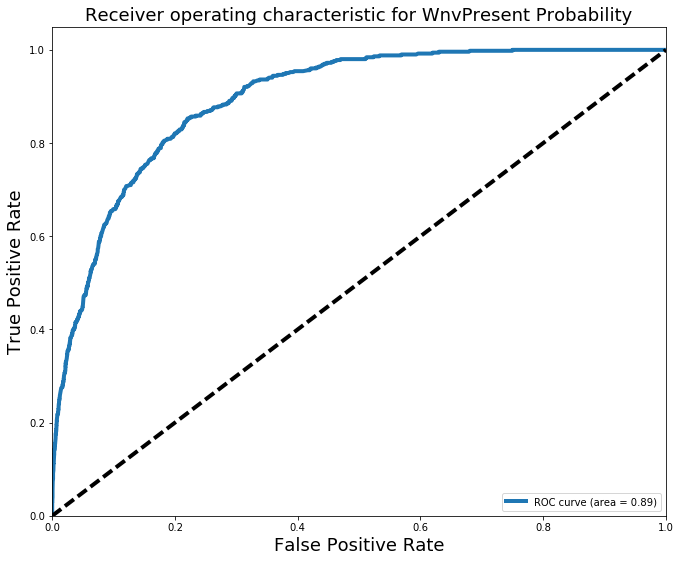

Generating output data:  



In [214]:
from sklearn.ensemble import GradientBoostingClassifier

# Running nearly entire run:
# This list uses almost everything with a value:


columns_of_interest = ["PIPIENS", "RESTUANS", "Tmax", "DewPoint", "WetBulb", "PrecipTotal",
                       "StnPressure", "ResultSpeed", "Days_Since_Spray", "Dist_to_Closest_Spray",
                       "Week", "DaylightMinutes", "TrapCoded"]

X = train_data[columns_of_interest]
y = train_data["WnvPresent"]
X_to_test = test_data[columns_of_interest]

run_final_model_gb = make_predictions_gboost("No", "No", X, y, GradientBoostingClassifier(), 
                                   gboost_dict, X_to_test)

In [215]:
# Create a dataframe column of results
submission_column_gb = pd.DataFrame(run_final_model_gb, columns=["WnvPresent"])

# Create output dataframe and write to CSV
submission_df_gb = pd.concat([id_column, submission_column_gb], axis=1)

In [216]:
# Output the file

final_output_gb = submission_df_gb.to_csv("../assets/test_output_gb2.csv", 
                                        index = False, encoding = "utf-8")

# Returned to GridSearch
Included coded traps, running everything

In [6]:
train_data.columns

Index([u'Species', u'Block', u'Trap', u'Latitude', u'Longitude',
       u'AddressAccuracy', u'NumMosquitos', u'WnvPresent', u'YMD', u'PIPIENS',
       u'RESTUANS', u'SALINARIUS', u'TERRITANS', u'Station', u'Tmax', u'Tmin',
       u'DewPoint', u'WetBulb', u'Sunrise', u'Sunset', u'PrecipTotal',
       u'StnPressure', u'SeaLevel', u'ResultSpeed', u'ResultDir', u'AvgSpeed',
       u'Tavg_int', u'Normal_Temp', u'Depart_calc', u'RA', u'BR', u'TS', u'HZ',
       u'SN', u'FG', u'FG+', u'FU', u'DZ', u'VC', u'MI', u'BC',
       u'Days_Since_Spray', u'Dist_to_Closest_Spray', u'Week',
       u'DaylightMinutes', u'TrapCoded'],
      dtype='object')

In [8]:
test_data.columns

Index([u'Species', u'Block', u'Trap', u'Latitude', u'Longitude',
       u'AddressAccuracy', u'YMD', u'PIPIENS', u'RESTUANS', u'SALINARIUS',
       u'TERRITANS', u'Station', u'Tmax', u'Tmin', u'DewPoint', u'WetBulb',
       u'Sunrise', u'Sunset', u'PrecipTotal', u'StnPressure', u'SeaLevel',
       u'ResultSpeed', u'ResultDir', u'AvgSpeed', u'Tavg_int', u'Normal_Temp',
       u'Depart_calc', u'RA', u'BR', u'TS', u'HZ', u'SN', u'FG', u'FG+', u'FU',
       u'DZ', u'VC', u'MI', u'BC', u'Days_Since_Spray',
       u'Dist_to_Closest_Spray', u'Week', u'DaylightMinutes', u'TrapCoded'],
      dtype='object')

In [ ]:
rforest_dict = {
    'criterion':('gini', 'entropy'),
    'n_estimators':[2, 4, 7, 10, 20],
    'max_features':[2, 3, 5, 8, 10, 0.2, 0.4, 0.6, 0.8, "sqrt", "log2", None],
    'max_depth':[4, 10, None],
    'min_samples_split':[2, 3, 5, 8, 10, 0.2, 0.4, 0.6, 0.8],
    'min_samples_leaf': [2, 3, 5, 8, 10, 0.2, 0.3, 0.4, 0.5]
    }

# increased columns to this:
# This list uses almost everything with a value:
columns_of_interest = ["Block", "Latitude", "Longitude", "AddressAccuracy", 
                      "PIPIENS", "RESTUANS", "SALINARIUS", "TERRITANS", "Tmax", "Tmin",
                      "Tavg_int", "DewPoint", "WetBulb", "PrecipTotal", "StnPressure", 
                      "SeaLevel", "ResultSpeed", "ResultDir", "AvgSpeed", "Normal_Temp", 
                      "RA", "BR", "TS", "HZ", "SN", "FG", "FU", "DZ", "VC", "MI", "BC", 
                      "Days_Since_Spray", "Dist_to_Closest_Spray", "Week", "DaylightMinutes", 
                      "TrapCoded"]

X = train_data[columns_of_interest]
X_to_test = test_data[columns_of_interest]
y = train_data["WnvPresent"]

run_final_model_gs_all = make_predictions("No", "Yes", X, y, RandomForestClassifier(), 
                                   rforest_dict, X_to_test)

In [ ]:
# Create a dataframe column of results
submission_column_search = pd.DataFrame(run_final_model_gs_all, columns=["WnvPresent"])

# Generated an output, but need to take back in the original target df
original_test = pd.read_csv('../assets/test.csv')
id_column = original_test["Id"]

# Create output dataframe and write to CSV
submission_df_search = pd.concat([id_column, submission_column_search], axis=1)

In [ ]:
# Output the file

final_output_search = submission_df_gb.to_csv("../assets/test_output_final_gs.csv", 
                                        index = False, encoding = "utf-8")